# Workspace preparation

## Installing and Importing Add-ins and libraries


In [1]:
!poetry add scikit-learn
!poetry add seaborn
!poetry add numpy

The following packages are already present in the pyproject.toml and will be skipped:

  - scikit-learn

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
Using version ^0.13.2 for seaborn

Updating dependencies
Resolving dependencies... (0.5s)Resolving dependencies... (0.1s)Resolving dependencies... (0.3s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing sklearn (0.0.post12): Pending...
  - Installing sklearn (0.0.post12): Preparing...
  - Installing sklearn (0.0.post12): Failed

  ChefBuildError

  Backend subprocess exited when trying to invoke get_requires_for_build_wheel
  
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands. 
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install skle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple



from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve,roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split

## Importing now our files from AWS

In [2]:
!aws s3 ls s3://zrive-ds-data/groceries/box_builder_dataset/ --recursive


2023-09-23 14:06:02  761678715 groceries/box_builder_dataset/feature_frame.csv


Then copying in local the file

In [3]:
!aws s3 cp s3://zrive-ds-data/groceries/box_builder_dataset/feature_frame.csv "/mnt/c/Users/Daniel Sánchez/Desktop/ZRIVE DS/src/module_3/"


download: s3://zrive-ds-data/groceries/box_builder_dataset/feature_frame.csv to ../../../../../../mnt/c/Users/Daniel Sánchez/Desktop/ZRIVE DS/src/module_3/feature_frame.csv


In [2]:
dfpath="/home/dsa/projects/zrive-ds/feature_frame.csv"
df=pd.read_csv(dfpath)

## Understanding the DF

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df.describe()

,variant_id,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
count,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,...,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06
mean,3.401250e+13,2.978388e+12,3.750025e+12,3.289342e+00,1.153669e-02,2.113868e-02,6.092589e-04,2.290188e-03,3.629864e-03,1.272808e-01,...,5.492182e-02,3.538562e-03,5.134091e-02,2.072549e+00,3.312961e+01,3.523734e+01,2.645304e+01,3.143513e+01,3.088810e+01,2.594969e+01
std,2.786246e+11,2.446292e+11,1.775710e+11,2.140176e+00,1.067876e-01,1.438466e-01,2.467565e-02,4.780109e-02,6.013891e-02,1.268378e-01,...,3.276586e-01,5.938048e-02,3.013646e-01,3.943659e-01,3.707162e+00,1.057766e+01,7.168323e+00,1.227511e+01,4.330262e+00,3.278860e+00
min,3.361529e+13,2.807986e+12,3.046041e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.599349e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.414214e+00,0.000000e+00,7.000000e+00,2.828427e+00
25%,3.380354e+13,2.875152e+12,3.745901e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.394416e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.000000e+01,2.319372e+01,3.000000e+01,2.800000e+01,2.427618e+01
50%,3.397325e+13,2.902856e+12,3.812775e+12,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.105178e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.400000e+01,2.769305e+01,3.000000e+01,3.100000e+01,2.608188e+01
75%,3.428495e+13,2.922034e+12,3.874925e+12,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.352670e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,4.000000e+01,3.059484e+01,3.000000e+01,3.400000e+01,2.796118e+01
max,3.454300e+13,3.643302e+12,5.029635e+12,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.000000e+00,1.000000e+00,6.000000e+00,5.000000e+00,1.480000e+02,8.400000e+01,5.868986e+01,1.480000e+02,3.950000e+01,3.564191e+01


In [4]:
info_cols=["variant_id","order_id","user_id","created_at","order_date"]
label_col=["outcome"]
feature_cols=[col for col in df.columns if col not in info_cols +[label_col]]

In [5]:
categorical_cols=["product_type","vendor"]
binary_cols=["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols =[col for col in feature_cols if col not in categorical_cols + binary_cols]

In [6]:
order_sizes = df.groupby('order_id')['outcome'].sum()
filtered_orders=order_sizes[order_sizes>5].index
df_filtered=df[df["order_id"].isin(filtered_orders)]



In [7]:
# Group by 'order_date' and count unique 'order_id's
daily_orders = df_filtered.groupby('order_date')['order_id'].nunique().reset_index()

# Rename the column for clarity
daily_orders = daily_orders.rename(columns={'order_id': 'unique_order_count'})
daily_orders['order_date'] = pd.to_datetime(daily_orders['order_date']).dt.date


In [8]:
daily_orders['cumsum_ratio'] = daily_orders['unique_order_count'].cumsum() / daily_orders['unique_order_count'].sum()


<Axes: >

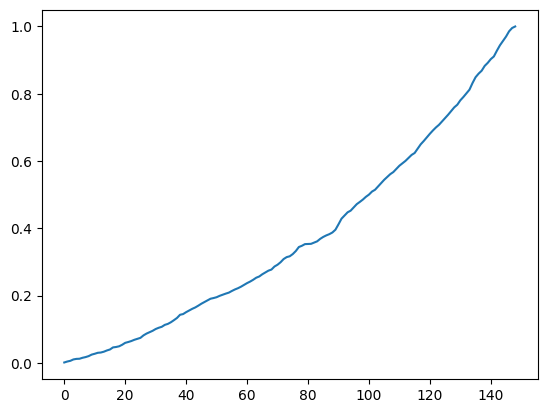

In [9]:
daily_orders['cumsum_ratio'].plot()

In [10]:
train_val_cutoff = daily_orders[daily_orders['cumsum_ratio'] <= 0.7].max()
val_test_cutoff= daily_orders[daily_orders['cumsum_ratio'] <= 0.9].max()



In [11]:
print('Training from',daily_orders['order_date'].min())
print("Train cutoff date:",train_val_cutoff['order_date'])
print("Validation cutoff date:",val_test_cutoff['order_date'])
print('Test until:',daily_orders['order_date'].max())


Training from 2020-10-05
Train cutoff date: 2021-02-05
Validation cutoff date: 2021-02-22
Test until: 2021-03-03


In [12]:
df_filtered.loc[:, 'order_date'] = pd.to_datetime(df_filtered['order_date']).dt.date

train_val_cutoff = train_val_cutoff.date() if hasattr(train_val_cutoff, 'date') else train_val_cutoff
val_test_cutoff = val_test_cutoff.date() if hasattr(val_test_cutoff, 'date') else val_test_cutoff



In [13]:
train_val_cutoff = pd.to_datetime(train_val_cutoff.iloc[0]).date()
val_test_cutoff = pd.to_datetime(val_test_cutoff.iloc[0]).date()


In [14]:
train_df = df_filtered[df_filtered['order_date'] <= train_val_cutoff]
val_df = df_filtered[(df_filtered['order_date'] > train_val_cutoff) & 
                     (df_filtered['order_date'] <= val_test_cutoff)]
test_df = df_filtered[df_filtered['order_date'] > val_test_cutoff]


# Baseline



As a first Baseline I am going to try to predict if something will be purchased (Outcome) based on the global popularity feature. 

In order to compare, we are going to start by preparing a function to plot Precision Recall and ROC curves, first for our baseline and then adding figures with our different models. 

The following function is for plting the curves. (Copy of Guille code)

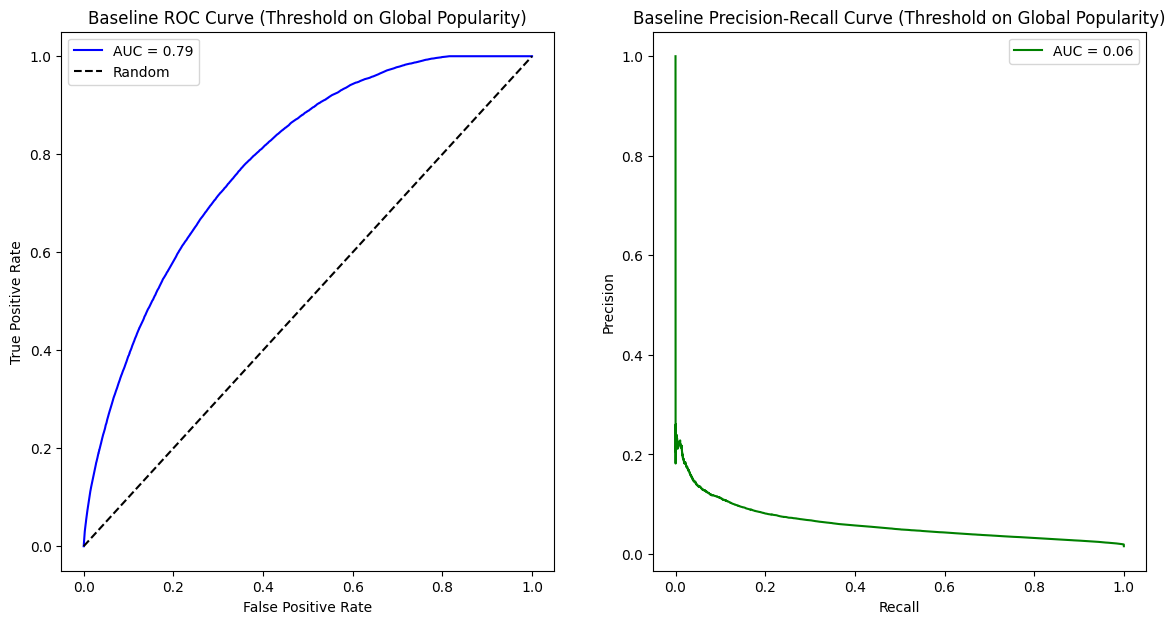

In [15]:

X = train_df[['global_popularity']]
y = train_df['outcome']


y_pred_baseline = (X['global_popularity'])

# Compute ROC curve and AUC for the baseline
fpr, tpr, _ = roc_curve(y, y_pred_baseline)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC for the baseline
precision, recall, _ = precision_recall_curve(y, y_pred_baseline)
pr_auc = auc(recall, precision)

# Plot ROC and Precision-Recall curves
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# ROC Curve
ax[0].plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
ax[0].plot([0, 1], [0, 1], "k--", label="Random")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Baseline ROC Curve (Threshold on Global Popularity)")
ax[0].legend()

# Precision-Recall Curve
ax[1].plot(recall, precision, color="green", label=f"AUC = {pr_auc:.2f}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Baseline Precision-Recall Curve (Threshold on Global Popularity)")
ax[1].legend()

# Show the plots
plt.show()



# Model Training
## Ridge


We are going to start training our model. Its a good idea to start using our binary and numerical features. I have decided first of all to review if I can predict the outcome based on global popularity. For That, I am using Logistic Regression first of all with Ridge. 


In [23]:
# Scale features
scaler = StandardScaler()
train_cols=binary_cols+numerical_cols
X_train_scaled = scaler.fit_transform(train_df[train_cols])
X_val_scaled = scaler.transform(val_df[train_cols])

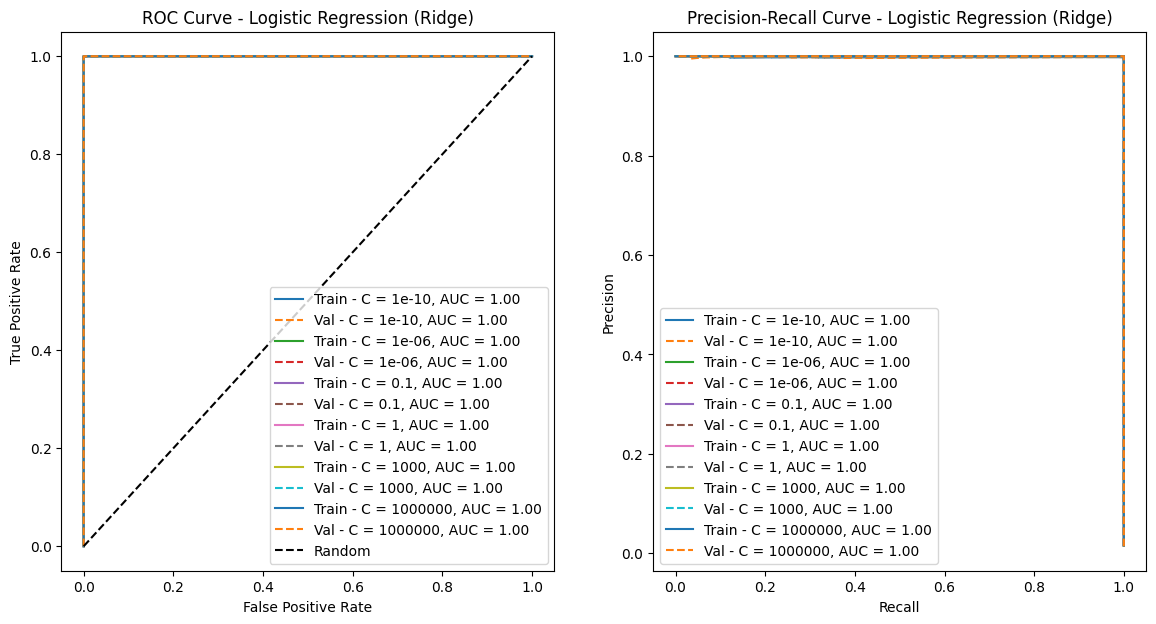

In [ ]:

# Define different values of C for comparison
C_values = [1e-10, 1e-6, 1e-1, 1, 1000, 1000000]

# Plot ROC and Precision-Recall curves for different values of C
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for C in C_values:
    # Fit the logistic regression model with L2 regularization (Ridge) and balanced class weights
    ridge_model = LogisticRegression(penalty="l2", C=C, class_weight="balanced")
    ridge_model.fit(X_train_scaled, train_df['outcome'])
    
    # Predict probabilities for training and validation sets
    train_proba = ridge_model.predict_proba(X_train_scaled)[:, 1]
    val_proba = ridge_model.predict_proba(X_val_scaled)[:, 1]
    
    # Compute ROC curve and AUC for training set
    fpr_train, tpr_train, _ = roc_curve(train_df['outcome'], train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    # Compute ROC curve and AUC for validation set
    fpr_val, tpr_val, _ = roc_curve(val_df['outcome'], val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    # Compute Precision-Recall curve and AUC for training set
    precision_train, recall_train, _ = precision_recall_curve(train_df['outcome'], train_proba)
    pr_auc_train = auc(recall_train, precision_train)
    
    # Compute Precision-Recall curve and AUC for validation set
    precision_val, recall_val, _ = precision_recall_curve(val_df['outcome'], val_proba)
    pr_auc_val = auc(recall_val, precision_val)
    
    # Plot ROC Curve (Train and Validation)
    ax[0].plot(fpr_train, tpr_train, label=f"Train - C = {C}, AUC = {roc_auc_train:.2f}")
    ax[0].plot(fpr_val, tpr_val, linestyle="--", label=f"Val - C = {C}, AUC = {roc_auc_val:.2f}")
    
    # Plot Precision-Recall Curve (Train and Validation)
    ax[1].plot(recall_train, precision_train, label=f"Train - C = {C}, AUC = {pr_auc_train:.2f}")
    ax[1].plot(recall_val, precision_val, linestyle="--", label=f"Val - C = {C}, AUC = {pr_auc_val:.2f}")

# Customize ROC Curve plot
ax[0].plot([0, 1], [0, 1], "k--", label="Random")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve - Logistic Regression (Ridge)")
ax[0].legend()

# Customize Precision-Recall Curve plot
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve - Logistic Regression (Ridge)")
ax[1].legend()

# Show the plots
plt.show()


For some reason, I am getting perfect Fit on the model, so clearly there is overfitting on this model. This could be due to some data-leakage that is leading to having a perfect fit on my model prediction.  

Also There are no changes in the model if I change the hyperparameter, so there is some mistake in here. 


## Lasso

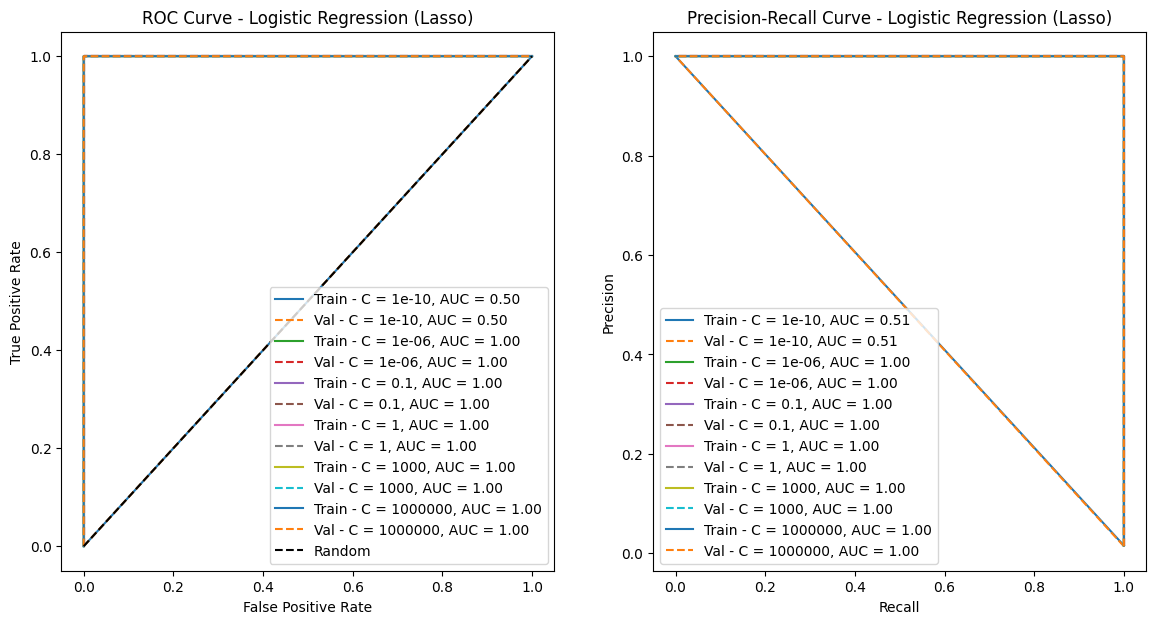

In [35]:
# Define different values of Hyperparameter for comparison
C_values = [1e-10, 1e-6, 1e-1, 1, 1000, 1000000]

# Plot ROC and Precision-Recall curves for different values of C
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

for C in C_values:
    # Fit the logistic regression model with L1 regularization (Lasso) and balanced class weights
    lasso_model = LogisticRegression(penalty="l1", C=C, class_weight="balanced", solver="liblinear")
    lasso_model.fit(X_train_scaled, train_df['outcome'])
    
    # Predict probabilities for training and validation sets
    train_proba = lasso_model.predict_proba(X_train_scaled)[:, 1]
    val_proba = lasso_model.predict_proba(X_val_scaled)[:, 1]
    
    # Compute ROC curve and AUC for training set
    fpr_train, tpr_train, _ = roc_curve(train_df['outcome'], train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    # Compute ROC curve and AUC for validation set
    fpr_val, tpr_val, _ = roc_curve(val_df['outcome'], val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    # Compute Precision-Recall curve and AUC for training set
    precision_train, recall_train, _ = precision_recall_curve(train_df['outcome'], train_proba)
    pr_auc_train = auc(recall_train, precision_train)
    
    # Compute Precision-Recall curve and AUC for validation set
    precision_val, recall_val, _ = precision_recall_curve(val_df['outcome'], val_proba)
    pr_auc_val = auc(recall_val, precision_val)
    
    # Plot ROC Curve (Train and Validation)
    ax[0].plot(fpr_train, tpr_train, label=f"Train - C = {C}, AUC = {roc_auc_train:.2f}")
    ax[0].plot(fpr_val, tpr_val, linestyle="--", label=f"Val - C = {C}, AUC = {roc_auc_val:.2f}")
    
    # Plot Precision-Recall Curve (Train and Validation)
    ax[1].plot(recall_train, precision_train, label=f"Train - C = {C}, AUC = {pr_auc_train:.2f}")
    ax[1].plot(recall_val, precision_val, linestyle="--", label=f"Val - C = {C}, AUC = {pr_auc_val:.2f}")

# Customize ROC Curve plot
ax[0].plot([0, 1], [0, 1], "k--", label="Random")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve - Logistic Regression (Lasso)")
ax[0].legend()

# Customize Precision-Recall Curve plot
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve - Logistic Regression (Lasso)")
ax[1].legend()

# Show the plots
plt.show()



Once again when Using Lassso, as expected looking at previous model, I get a "perfect model". This was expected since for doing Lasso I changed only few things, but the dataset I am working with is the same, hence we are getting same results since the origin of our problem should be shared between the two models. 


# Summary and Conclusions

I could not get good conclusions ince I got some problem with the data and I am getting highly overfitted models that do not allow me to draw a good conclusion. 

For that reason, I should find where is the data leakage and after that try to solve them again.
    